In [195]:
################ Correlation between stock and sentiments ###
#Calculating sentiments using vader and watson for a stock and then comparing the stock variation by plotting all
#### Also used wordcloud to understand the noice around a stock from tweets
########

################################### Declare all relevant dependencies##############
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import requests as req
import time
import io
import os
import csv
from datetime import datetime
from wordcloud import WordCloud
##load citipy for weather
from citipy import citipy
# Import Watson Sentiment Analyzer
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

## For Stock using alpha_vantage dependencies
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint

###############################################AUTHENTICATION BEGINS HERE ##############################
## Alpha_Vantage Authentication - for stock
ts = TimeSeries(key='XZ4ZWEA0IQ22O9XT',output_format='pandas',indexing_type='date')


## Get Authentication for Twitter requests, entering keys
consumer_key="akczLSsb7D39rCQITi6HKKTbS"
consumer_secret="ZzlplKxUh1agPMHRjouqC1E3T6gdssATmU2e1kiFupNodEwmrH"
access_token="41056206-bpASiEYIYW7gti7fvZjm1ckaQfskqwMfUIDyfcGRQ"
access_token_secret="AYjW9Maj2nOELJ7LLEj6YrfXmVqjYWN0lBpX4ariTXED2"

## Get IBM Authentication
natural_language_understanding = NaturalLanguageUnderstandingV1(
  username='eead473e-d77e-4ab6-bbcf-48196a0cb3e6',
  password='4e1sOJAWwIIB',
  version='2017-02-27')

## Get Weather API Key
api_key = "62e6c158794571605e5f2b3046aa6eac"
######################################################################################
########Target Stocks########## 
### Note: currently I am only analyzing/plotting only Shell ##
target_user=("@Shell","@exxonmobil","Chevron","@DevonEnergy")
### corresponding ticker symbols are


In [196]:
############### Get entire city and country list for a URL and then play with it #################
url="http://openweathermap.org/help/city_list.txt"
s=req.get(url)
city_file = open('city_list.txt', 'w',encoding="utf-8")
for item in s.text:
    city_file.write("%s" %item)
    
import csv
in_txt = csv.reader(open('city_list.txt'), delimiter = '\t')
out_csv = csv.writer(open('city_out.csv', 'w'))
out_csv.writerows(in_txt)
############################# Put that into Dataframe ########################     
df = pd.read_csv('city_out.csv')
df.head()

,id,nm,lat,lon,countryCode
0,819827,Razvilka,55.591667,37.740833,RU
1,524901,Moscow,55.752220,37.615555,RU
2,1271881,Firozpur Jhirka,27.799999,76.949997,IN
3,1283240,Kathmandu,27.716667,85.316666,NP
4,703448,Kiev,50.433334,30.516666,UA


In [197]:
############# Lest's Collect  US cities information ######################
df.rename(columns={'nm':'city','countryCode':'countrycode'},inplace=True)
df.set_index("id", inplace=True)
df.head()

,city,lat,lon,countrycode
id,,,,
819827,Razvilka,55.591667,37.740833,RU
524901,Moscow,55.752220,37.615555,RU
1271881,Firozpur Jhirka,27.799999,76.949997,IN
1283240,Kathmandu,27.716667,85.316666,NP
703448,Kiev,50.433334,30.516666,UA


In [198]:
df_us=df.loc[df['countrycode'] == 'US']
df_us.head()

,city,lat,lon,countrycode
id,,,,
7262440,Valencia West,32.132381,-111.114143,US
5495380,Tularosa,33.073971,-106.018600,US
5301442,Lake of the Woods,34.163929,-109.989548,US
4190542,Dahlonega,34.532589,-83.984909,US
5322400,Adelanto,34.582771,-117.409218,US


In [199]:
###########################  Get weather Data, idea is to capture storms or rain around the world ######################
url = "http://api.openweathermap.org/data/2.5/weather?"


# Dropping duplicates for clean start
city_pd=df_us.drop_duplicates()
city_pd.head()

# Create columns in dataframe for future use , here we are capturing temp and windspeed, I will changeto relevant ####
city_pd["temp"] = ""
city_pd["windspeed"] = ""
city_pd["weather_id"]=""
city_pd["weather_type"]=""
city_pd["weather_desc"]=""

#len(city_pd)

# Counter, we will collect 100 cities or you can change the counter condition to collect more cities
row_count = 0

# Loop through city and country codes and grab the weather such as snow storm or rain 

for index, row in city_pd.iterrows():
   
     target_url = "http://api.openweathermap.org/data/2.5/weather?q=%s&units=IMPERIAL&mode=json&APPID=%s" %(row["city"],api_key)
  # Print check to ensure loop is working correctly
     #** ignore this line--  print("Now retrieving city #"+ str(row_count)+" City Name"+row["city"])
     
    #print(target_url)
     row_count+=1
     if row_count == 100:
            break
    # Run requests to grab the JSON at the requested URL
     city_weather = req.get(target_url).json()
     #print(city_weather)
     #print(city_weather['weather'][0]['id'])
     #print(city_weather['weather'][0]['main'])
     #print(city_weather['weather'][0]['description'])

    # Use try / except to skip any cities with errors
     try: 
                city_temp = city_weather["main"]["temp_max"]
                city_wind=city_weather["wind"]["speed"]
                city_wid=city_weather["weather"][0]['id']
                city_type=city_weather["weather"][0]['main']
                city_desc=city_weather["weather"][0]['description']
                city_pd.set_value(index, "temp", city_temp)
                city_pd.set_value(index, "windspeed", city_wind)
                city_pd.set_value(index,"weather_id",city_wid)
                city_pd.set_value(index,"weather_type",city_type)
                city_pd.set_value(index,"weather_desc",city_desc)
        
             
     except:
                print("Error with city data. Skipping")
                continue

In [200]:
# Visualize
city_pd.replace('',np.nan,inplace=True)
city_pd.dropna(axis=0,how='any')

,city,lat,lon,countrycode,temp,windspeed,weather_id,weather_type,weather_desc
id,,,,,,,,,
7262440,Valencia West,32.132381,-111.114143,US,78.80,4.70,800.0,Clear,clear sky
5495380,Tularosa,33.073971,-106.018600,US,59.00,4.70,800.0,Clear,clear sky
5301442,Lake of the Woods,34.163929,-109.989548,US,62.60,12.75,500.0,Rain,light rain
4190542,Dahlonega,34.532589,-83.984909,US,51.80,2.10,800.0,Clear,clear sky
5322400,Adelanto,34.582771,-117.409218,US,69.80,9.17,721.0,Haze,haze
4270936,Ellis,38.938068,-99.560669,US,69.80,16.11,800.0,Clear,clear sky
5445194,Colby,39.395840,-101.052383,US,69.80,6.93,800.0,Clear,clear sky
4902065,Metamora,40.790588,-89.360641,US,44.60,13.87,800.0,Clear,clear sky
5106014,Wanaque,41.038151,-74.294037,US,37.40,5.84,800.0,Clear,clear sky


In [201]:
## Get Stock data
#data=pd.DataFrame({})
#meta_data = ts.get_intraday(symbol='MSFT',interval='1min', outputsize='full')
#pprint(data.head(2))
data, meta_data = ts.get_intraday(symbol='RDS.A',outputsize='full')

In [202]:
data.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2018-01-05 09:30:00,68.7900,68.791,68.770,68.780,52894.0
2018-01-05 09:45:00,68.7900,68.830,68.675,68.820,144077.0
2018-01-05 10:00:00,68.8063,68.900,68.800,68.873,69843.0
2018-01-05 10:15:00,68.8850,68.885,68.810,68.850,127724.0
2018-01-05 10:30:00,68.8500,68.860,68.740,68.755,188630.0


In [203]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)
api=tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [204]:
# Target Search Term
#target_user = ("@OPECnews", "@Shell", "@exxonmobil", "@Chevron", "@conocophillips", "@OXY_Petroleum", 
             #   "@ValeroEnergy", "@Phillips66Co", "@MarathonPetroCo", "@DevonEnergy")

#target_user = ("@Shell", "@exxonmobil", "@Chevron", "@DevonEnergy")
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
user_list = []
tweet_times = []
tweet_count = []
tweet_text = []
tweet_mean = []


In [205]:
## Function to capture compound mean that we can use in Seaborn plotting


for user in target_user:
   
    counter=1
    
    for x in range(5):
        public_tweets = api.user_timeline(user,page=x)
        for tweet in public_tweets:
            # small test #print("Tweet from %s #%s:%s" %(user,counter,tweet["text"]))
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweet_datetime = datetime.strptime(tweet["created_at"],"%a %b %d %H:%M:%S %z %Y")
            ## Remove below # to test print of tweets
            #print("Tweet from %s #%s created on %s:%s" %(user,tweet_datetime,counter,tweet["text"]))
        
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)
            user_list.append(user)
            tweet_times.append(tweet_datetime)
            tweet_count.append(counter)
            tweet_text.append(tweet["text"])
            counter = counter +1

    #print("Total number of tweets %s" %str(counter -1))
    #print(" ---------------TWEET COMPLETED FOR %s-------------" %user)
    
    #Print the Averages
    #print("")
    #print("User: %s" % user)
    #print("Compound: %s" % np.mean(compound_list))
    tweet_mean.append(np.mean(compound_list))
    #print("Positive: %s" % np.mean(positive_list))
    #print("Neutral: %s" % np.mean(neutral_list))
    #print("Negative: %s" % np.mean(negative_list))
    #print("------------Calculated the average-----")
            

In [206]:
# Defining a dataframe
sentiment=pd.DataFrame({
            "User":user_list,
            "Tweet_count":tweet_count,
            "Tweet_date":tweet_times,
            "Tweet_text":tweet_text,
           "Compound":compound_list,
           "Positive":positive_list,
           "Neutral":neutral_list,
            "Negative":negative_list})
# Organize Dataframe
sentiment = sentiment[["User","Tweet_count","Tweet_date","Tweet_text","Compound","Positive","Neutral","Negative"]]

In [207]:
sentiment.head()

,User,Tweet_count,Tweet_date,Tweet_text,Compound,Positive,Neutral,Negative
0,@Shell,1,2018-01-19 16:15:13+00:00,@LaurenceKC Seems like #FridayFun! Enjoy #make...,0.7418,0.512,0.488,0.000
1,@Shell,2,2018-01-19 16:00:34+00:00,@Pavegen Good to see you guys ready to #maketh...,0.6900,0.363,0.637,0.000
2,@Shell,3,2018-01-18 16:22:46+00:00,RT @Shell_NatGas: No sun? ☀️ No wind? 🌬️ No pr...,-0.2640,0.187,0.539,0.274
3,@Shell,4,2018-01-18 12:07:00+00:00,"@PeewitPro Hello, please link up with #ShellLi...",0.5859,0.242,0.758,0.000
4,@Shell,5,2018-01-18 10:36:00+00:00,@enerstrat We're quite #proud of the team too!...,0.0000,0.000,1.000,0.000


In [208]:
## Sort by Date
sentiment=sentiment.sort_values(by='Tweet_date', ascending = False)
sentiment.head()

,User,Tweet_count,Tweet_date,Tweet_text,Compound,Positive,Neutral,Negative
200,Chevron,1,2018-01-19 22:02:28+00:00,@clairemetzwesh Hi Clair- Thx 4 bringing this ...,0.6369,0.257,0.743,0.0
220,Chevron,21,2018-01-19 22:02:28+00:00,@clairemetzwesh Hi Clair- Thx 4 bringing this ...,0.6369,0.257,0.743,0.0
320,@DevonEnergy,21,2018-01-19 20:47:47+00:00,We visited Hinton Public Schools this morning ...,0.6597,0.252,0.748,0.0
300,@DevonEnergy,1,2018-01-19 20:47:47+00:00,We visited Hinton Public Schools this morning ...,0.6597,0.252,0.748,0.0
120,@exxonmobil,21,2018-01-19 20:38:38+00:00,Ever wonder why gas prices differ from state t...,0.0000,0.000,1.000,0.0


In [209]:
sentiment['User'].unique()

array(['Chevron', '@DevonEnergy', '@exxonmobil', '@Shell'], dtype=object)

In [211]:
################ ANALYZE IBM WATSON SENTIMENTS USING natutal language analyzer #################
y=[]
score=[]
label=[]
target=[]
Tweet_count_watson=[]
#user=("@OPECnews")
tweet_analyze=[]


for user in target_user:
    y=sentiment['Tweet_text'][sentiment["User"] == user]
    #print(y)
    y.to_csv("tweets.txt", index=False, header=True)
    counter=1
    for i in y:
        strip_text=i.strip('RT @')
       #print(strip_text)
        try:
            z=natural_language_understanding.analyze(text=strip_text,features=Features(entities=EntitiesOptions(sentiment=True), keywords=KeywordsOptions(sentiment=True)))
            #print(json.dumps(z, indent=2))
            #print(z['entities'])
            ## I saw errors specially when the text is less or tweet is small,hence have to use try/Except
            ## Also , I had issues with emty list,some tweets get missed in calculating sentiments
        except: 
                continue
        if not z['entities']:
            pass
        else:
            ##########You can add/remove below has to see the sentiment###
            ## REMOVE the below comment to see the the sentiments 
            #print(z['entities'][0]['sentiment'])
            ################################################
            target.append(user)
            #print(user)
            Tweet_count_watson.append(counter)
            tweet_analyze.append(strip_text)
            score.append(z['entities'][0]['sentiment']['score'])
            label.append(z['entities'][0]['sentiment']['label']) 
            tweet_text.append(tweet["text"])
            counter=counter+1


In [213]:
##Watson_dataframe to organize into dataframe for above collected sentiments ###
### Note:Takes some time for output
watson_df=pd.DataFrame({
                 'targetuser':target,
                 'Tweet_count':Tweet_count_watson,
                 'tweet':tweet_analyze,
                'score':score,
                'label':label})
# Organize Dataframe
watson_df = watson_df[["targetuser","Tweet_count","tweet","score","label"]]
watson_df

,targetuser,Tweet_count,tweet,score,label
0,@Shell,1,LaurenceKC Seems like #FridayFun! Enjoy #maket...,0.365305,positive
1,@Shell,2,LaurenceKC Seems like #FridayFun! Enjoy #maket...,0.365305,positive
2,@Shell,3,Pavegen Good to see you guys ready to #makethe...,0.622616,positive
3,@Shell,4,Pavegen Good to see you guys ready to #makethe...,0.622616,positive
4,@Shell,5,Shell_NatGas: No sun? ☀️ No wind? 🌬️ No proble...,0.575830,positive
5,@Shell,6,Shell_NatGas: No sun? ☀️ No wind? 🌬️ No proble...,0.575829,positive
6,@Shell,7,"PeewitPro Hello, please link up with #ShellLiv...",0.000000,neutral
7,@Shell,8,"PeewitPro Hello, please link up with #ShellLiv...",0.000000,neutral
8,@Shell,9,enerstrat We're quite #proud of the team too! ...,0.000000,neutral
9,@Shell,10,enerstrat We're quite #proud of the team too! ...,0.000000,neutral


In [214]:
# Push the sentiments DataFrame to a new CSV file for each vader and Watson
sentiment.to_csv("sentiment_by_vader.csv", index=False, header=True)
watson_df.to_csv("sentiment_by_watson.csv",index=False,header=True)
 


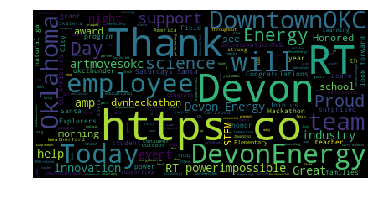

In [216]:
### Checking tweets for words##
%matplotlib inline
# generate a word cloud to check on the buzz words#
 
f = open("tweets.txt", "r")
text = f.read()
 
from wordcloud import WordCloud
wordcloud = WordCloud().generate(text)
 
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
 
wordcloud = WordCloud(max_font_size=50, relative_scaling=.1).generate(text)
 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

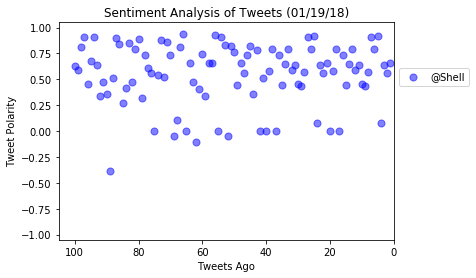

In [217]:
#c=("blue","darkgreen","red","darkblue","yellow","orange")
#target_user = ("@OPECnews", "@Shell", "@exxonmobil", "@Chevron", "@conocophillips", "@OXY_Petroleum")
#counter=1
#for user in target_user:
    #for color in c:
### Sorting by time of tweets and assigning to each dataframe
#target_user = ("@Shell", "@exxonmobil", "@Chevron", "@DevonEnergy")
plot_vader_sentiment=sentiment[sentiment['User']==user]
vader_sentiment_df=plot_vader_sentiment.sort_values(by='Tweet_date', ascending = False)
    ## Incorporate the scatter plot
    # Target Search Term
    #target_user = ("@OPECnews", "@Shell", "@exxonmobil", "@Chevron", "@conocophillips", "@OXY_Petroleum", 
                   # "@ValeroEnergy", "@Phillips66Co", "@MarathonPetroCo", "@DevonEnergy")
ax1=vader_sentiment_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="blue",s=50, alpha=0.5, label='@Shell')
        #ax+str(counter)=vader_sentiment.plot(kind='scatter',x = "Tweet_count", y = "Compound",c='color',s=50, alpha=0.5, label='@BBC')
        #ax2=CBS_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="darkgreen", s=50, alpha=0.5, label='@CBS',ax=ax1)
        #ax3=CNN_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="red", s=50, alpha=0.5, label='@CNN',ax=ax2)
        #ax4=FoxNews_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="darkblue", s=50, alpha=0.5, label='@FoxNews',ax=ax3)
        #ax5=nytimes_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="yellow",s=50, alpha=0.5, label='@nytimes',ax=ax4)
plt.title("Sentiment Analysis of Tweets (%s)" % time.strftime("%x"))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.ylim([-1.05,1.05])
plt.xlim([105,0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.75))
plt.savefig("Sentiment_Analysis_of_tweets.png")
plt.show()
        #counter=counter+1

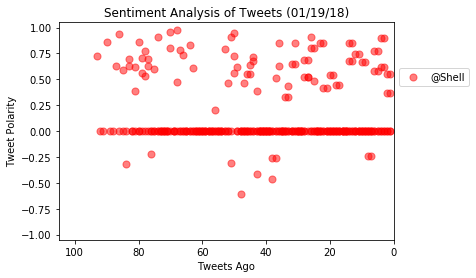

In [218]:
ax1=watson_df.plot(kind='scatter',x = "Tweet_count", y = "score",c="red",s=50, alpha=0.5, label='@Shell')
        #ax+str(counter)=vader_sentiment.plot(kind='scatter',x = "Tweet_count", y = "Compound",c='color',s=50, alpha=0.5, label='@BBC')
        #ax2=CBS_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="darkgreen", s=50, alpha=0.5, label='@CBS',ax=ax1)
        #ax3=CNN_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="red", s=50, alpha=0.5, label='@CNN',ax=ax2)
        #ax4=FoxNews_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="darkblue", s=50, alpha=0.5, label='@FoxNews',ax=ax3)
        #ax5=nytimes_df.plot(kind='scatter',x = "Tweet_count", y = "Compound",c="yellow",s=50, alpha=0.5, label='@nytimes',ax=ax4)
plt.title("Sentiment Analysis of Tweets (%s)" % time.strftime("%x"))
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.ylim([-1.05,1.05])
plt.xlim([105,0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.75))
plt.savefig("Sentiment_Analysis_of_tweets.png")
plt.show()
        #counter=counter+1

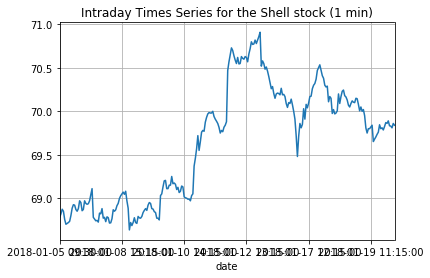

In [219]:
# Heading
data.describe()
data['4. close'].plot()
plt.title('Intraday Times Series for the Shell stock (1 min)')
plt.grid()
plt.show()

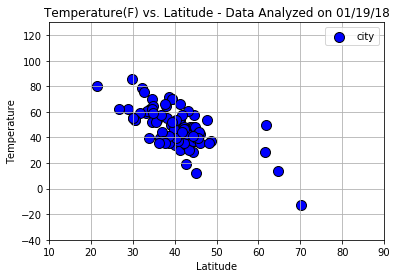

In [231]:
# #################Plotting weather ###############
import time
plt.scatter(city_pd["lat"], city_pd["temp"], color='b',edgecolor="black",linewidths=1,marker="o",s=100,alpha=1,label='city')
plt.title("Temperature(F) vs. Latitude - Data Analyzed on %s" %(time.strftime("%x")))
plt.ylabel("Temperature")
plt.xlabel("Latitude")
plt.grid(True)
plt.xlim([10,90])
plt.ylim([-40,130])
plt.legend()